# Understanding the Hill Model for Multi-Channel Marketing Spend

## Objective
Estimate **total revenue** as a function of **spend across multiple ad channels** (Digital, TV, Search, Radio, etc.)  
using a nonlinear **Hill transformation** to capture **diminishing returns** and **saturation** effects.

---

## The Multi-Channel Hill Formula

\[
\hat{y} \;=\; \gamma \;+\; \sum_{c \in \{\text{Digital, TV, Search, Radio, …}\}}
\alpha_c \cdot \frac{x_c^{\beta_c}}{x_c^{\beta_c} + \theta_c^{\beta_c}}
\]

| Symbol | Meaning | Intuition |
|:--:|:--|:--|
| \(x_c\) | Spend for channel *c* | Input variable (e.g., $ k) |
| \( \alpha_c \) | **Plateau** | Maximum revenue contribution from that channel |
| \( \beta_c \) | **Steepness** | How quickly returns grow before saturation |
| \( \theta_c \) | **Half-saturation spend** | Spend where ~50 % of α₍c₎ is achieved |
| \( \gamma \) | **Baseline** | Organic or brand revenue with zero paid spend |

---

## Why the Hill Transformation
- **Low spend** → near-linear lift  
- **Medium spend** → **diminishing returns**  
- **High spend** → **plateau** (saturation)

This makes it ideal for **marketing-mix modeling** where additional spend yields progressively smaller revenue gains.

---

## Expected Data Structure
Typical dataset (weekly or monthly observations):

| date | Digital_Spend | TV_Spend | Search_Spend | Radio_Spend | Revenue |
|------|---------------:|----------:|--------------:|-------------:|--------:|
| 2024-01-01 | 50 | 40 | 25 | 15 | 420 |
| 2024-01-08 | 60 | 50 | 30 | 20 | 470 |
| … | … | … | … | … | … |

All spends and revenue in consistent units (e.g., \$ k).

---

## Practical Fitting Notes
- **Units:** choose \$ or \$ k and stay consistent.  
- **Scaling:** normalize spends/revenue to ~[0, 1] for stable fitting; rescale parameters afterward.  
- **Bounds:** enforce positive α, β, θ; constrain β within [0, 10] for realism.  
- **Baseline γ:** captures organic/brand revenue not driven by paid media.

---

 **Next → Step 2**  
Fit the Hill curve for a **single channel** (e.g., Digital) to interpret  
α (plateau), β (steepness), θ (half-saturation) before expanding to multi-channel joint fits.


In [22]:
from typing import Annotated
import sys
import os
from typing_extensions import TypedDict, Literal
from langgraph.graph import MessagesState  # Add this import
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import AzureChatOpenAI
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from langgraph_playground.multiagent_framework.utils import *
from azure.search.documents import SearchClient
from langchain_core.runnables import RunnableConfig
import logging
from langchain_core.tools import tool
import json
from langchain_core.messages import ToolCall
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from azure.ai.projects import AIProjectClient
from databricks_langchain.genie import GenieAgent
from databricks.sdk import WorkspaceClient
from databricks_ai_bridge.genie import  Genie, GenieResponse
from operator import add

# Install: pip install -U "psycopg[binary,pool]" langgraph langgraph-checkpoint-postgres

from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.store.postgres import PostgresStore
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
import uuid
from langmem.short_term import RunningSummary  # Add this import
import psycopg  # Add this import

c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\pydantic\_internal\_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\databricks_ai_bridge\vector_search_retriever_tool.py:107: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("tool_name")
c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\trustcall\_base.py:46: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constant

In [5]:
"""
Goal
----
Fit a multi-channel Hill model that estimates total Revenue from multiple ad-channel spends:
  y_hat = gamma + sum_c alpha_c * (x_c^beta_c) / (x_c^beta_c + theta_c^beta_c)

Where:
  x_c     : spend for channel c (same unit across channels, e.g., $k)
  alpha_c : plateau (max contribution) for channel c (revenue units, e.g., $k)
  beta_c  : steepness/shape for channel c (unitless)
  theta_c : half-saturation spend for channel c (spend units, e.g., $k)
  gamma   : baseline (organic) revenue ($k)

Notes
-----
- We fit all channels' parameters jointly for consistency.
- We scale X (per-channel) and y to ~[0,1] for stable optimization, then rescale parameters back.
- Bounds keep parameters sensible; beta is unitless and constrained (e.g., [0,10]).
- After fitting, use predict_revenue_multichannel(spends_dict) without refitting.
"""

import numpy as np
import pandas as pd
from scipy.optimize import least_squares

"""
A) Imports + example dataset (units: $k)
- Channels: Meta, YouTube, TikTok
- Revenue: total in $k
"""

# Example actual-looking weekly data (8 rows)
df = pd.DataFrame({
    "Meta_Spend":    [40, 50, 60, 70, 80,  90, 100, 110],
    "YouTube_Spend": [30, 40, 45, 55, 60,  70,  75,  85],
    "TikTok_Spend":  [15, 20, 25, 25, 30,  35,  40,  45],
    "Revenue":       [350,400,445,480,520, 560, 595, 630]
})
channels = ["Meta_Spend", "YouTube_Spend", "TikTok_Spend"]
C = len(channels)

print(df.head(2))
print("\n\n")
print("Number of channels:", C) # 3 channels

   Meta_Spend  YouTube_Spend  TikTok_Spend  Revenue
0          40             30            15      350
1          50             40            20      400



Number of channels: 3


In [7]:
"""
B) Single-channel Hill contribution (saturation):
    h(x) = alpha * x^beta / (x^beta + theta^beta)

Args
- x:     spend (same unit as theta), here $k
- alpha: plateau (max contribution) in revenue units ($k)
- beta:  steepness/shape (unitless)
- theta: half-saturation spend (spend units, $k)
"""
def hill_term(x, alpha, beta, theta):
    x = np.asarray(x, float)
    x = np.clip(x, 1e-9, None)  # guard tiny/zero
    return alpha * (x**beta) / (x**beta + theta**beta)


In [6]:
"""
C) Prepare X, y and scale to ~[0,1]
- Xs: scaled spends per channel (divide each column by its max)
- ys: scaled revenue (divide by y.max)
"""
X = df[channels].to_numpy(float)   # (n, C)
y = df["Revenue"].to_numpy(float)  # (n,)

x_max = X.max(axis=0)  # per-channel max (Meta, YouTube, TikTok)
y_max = y.max()

Xs = X / x_max
ys = y / y_max

Xs, ys, x_max, y_max

print("Scaled values:")
print("Xs:", Xs)
print("ys:", ys)
print("x_max:", x_max)
print("y_max:", y_max)

Scaled values:
Xs: [[0.36363636 0.35294118 0.33333333]
 [0.45454545 0.47058824 0.44444444]
 [0.54545455 0.52941176 0.55555556]
 [0.63636364 0.64705882 0.55555556]
 [0.72727273 0.70588235 0.66666667]
 [0.81818182 0.82352941 0.77777778]
 [0.90909091 0.88235294 0.88888889]
 [1.         1.         1.        ]]
ys: [0.55555556 0.63492063 0.70634921 0.76190476 0.82539683 0.88888889
 0.94444444 1.        ]
x_max: [110.  85.  45.]
y_max: 630.0


In [10]:
Xs.shape[0]  # (n, C)

8

### Scaled Multi-Channel Model + Residuals + Fit

In [12]:
"""
D) Scaled multi-channel model and joint fit
Parameter vector layout (length = 3*C + 1):
    p = [alpha_s1, beta1, theta_s1, ..., alpha_sC, betaC, theta_sC, gamma_s]
Where:
- alpha_s: plateau in scaled y units
- beta:    unitless
- theta_s: half-sat in scaled x units
- gamma_s: baseline in scaled y units
"""

def multi_hill_scaled(Xs, p):
    n = Xs.shape[0]
    yhat = np.zeros(n, float)
    k = 0
    for c in range(C):
        a_s, b, t_s = p[k], p[k+1], p[k+2]
        yhat += hill_term(Xs[:, c], a_s, b, t_s)  # pass scaled params directly
        k += 3
    gamma_s = p[-1]
    return yhat + gamma_s

# Initial guesses + bounds in SCALED space
p0, lb, ub = [], [], []
for _ in range(C):
    p0 += [1.0, 1.0, 0.5]   # alpha_s≈1, beta≈1, theta_s≈0.5
    lb += [0.0, 0.0, 0.0]
    ub += [5.0,10.0, 5.0]
p0 += [0.1]                 # gamma_s
lb += [0.0]
ub += [1.5]

p0 = np.array(p0, float)
lb = np.array(lb, float)
ub = np.array(ub, float)

def resid(p):
    return multi_hill_scaled(Xs, p) - ys

res = least_squares(
    resid, x0=p0, bounds=(lb, ub),
    loss="soft_l1", f_scale=0.1, max_nfev=50000
)

print("optimization values:", res)
res.success, res.cost


optimization values:      message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.187e-10 -1.209e-10 -1.070e-10 -1.062e-10 -1.270e-10
               -9.251e-11 -6.437e-11 -8.334e-11]
           x: [ 1.051e+00  1.325e+00  1.028e+00  3.231e-01  1.095e+00
                3.056e+00  4.892e-01  1.378e+00  2.075e+00  2.795e-01]
        cost: 0.0
         jac: [[ 2.015e-01 -1.757e-01 ... -2.240e-02  1.000e+00]
               [ 2.533e-01 -1.622e-01 ... -3.101e-02  1.000e+00]
               ...
               [ 4.595e-01 -3.200e-02 ... -5.879e-02  1.000e+00]
               [ 4.910e-01 -7.163e-03 ... -6.371e-02  1.000e+00]]
        grad: [-2.826e-10  8.662e-11  2.414e-10 -1.252e-10  5.154e-11
                1.210e-11 -1.302e-10  6.057e-11  3.465e-11 -8.201e-10]
  optimality: 1.1161180672057257e-09
 active_mask: [0 0 0 0 0 0 0 0 0 0]
        nfev: 266
        njev: 198


(True, 0.0)

## Rescale Parameters Back to Real Units

In [13]:
"""
E) Rescale optimized parameters back to original units
- alpha:  plateau in revenue units ($k)      → alpha = alpha_s * y_max
- beta:   unitless                            → beta = beta
- theta:  half-saturation in spend units ($k) → theta = theta_s * x_max[channel]
- gamma:  baseline in revenue units ($k)      → gamma = gamma_s * y_max
"""
p_opt = res.x

params = {}
k = 0
for i, ch in enumerate(channels):
    alpha_s, beta, theta_s = p_opt[k], p_opt[k+1], p_opt[k+2]
    params[ch] = {
        "alpha": float(alpha_s * y_max),
        "beta":  float(beta),
        "theta": float(theta_s * x_max[i])
    }
    k += 3
gamma = float(p_opt[-1] * y_max)

params, gamma

({'Meta_Spend': {'alpha': 662.1640047600896,
   'beta': 1.325172297996246,
   'theta': 113.04096793551533},
  'YouTube_Spend': {'alpha': 203.53842449728856,
   'beta': 1.0953477030866479,
   'theta': 259.76597631680755},
  'TikTok_Spend': {'alpha': 308.20240625395786,
   'beta': 1.3780947994302124,
   'theta': 93.36775268569924}},
 176.10172678641277)

### Predictor for New Spend Mixes

In [14]:
"""
F) Predict total revenue ($k) for a dict of channel spends ($k)
spends example: {"Meta_Spend": 90, "YouTube_Spend": 70, "TikTok_Spend": 35}
"""
def predict_revenue_multichannel(spends: dict) -> float:
    yhat = gamma
    for ch in channels:
        x_val = float(spends.get(ch, 0.0))
        p = params[ch]
        yhat += hill_term(x_val, p["alpha"], p["beta"], p["theta"])
    return float(yhat)


### Quick Examples

In [15]:
"""
G) Quick predictions (no refit)
"""
ex1 = {"Meta_Spend": 85, "YouTube_Spend": 65, "TikTok_Spend": 30}
ex2 = {"Meta_Spend": 100, "YouTube_Spend": 80, "TikTok_Spend": 40}

print("Baseline gamma ($k):", round(gamma, 2))
print("Params per channel:", params)
print("Pred ex1 ($k):", round(predict_revenue_multichannel(ex1), 1))
print("Pred ex2 ($k):", round(predict_revenue_multichannel(ex2), 1))

Baseline gamma ($k): 176.1
Params per channel: {'Meta_Spend': {'alpha': 662.1640047600896, 'beta': 1.325172297996246, 'theta': 113.04096793551533}, 'YouTube_Spend': {'alpha': 203.53842449728856, 'beta': 1.0953477030866479, 'theta': 259.76597631680755}, 'TikTok_Spend': {'alpha': 308.20240625395786, 'beta': 1.3780947994302124, 'theta': 93.36775268569924}}
Pred ex1 ($k): 535.3
Pred ex2 ($k): 597.4


### Compact Visual Check per Channel (One-at-a-time)

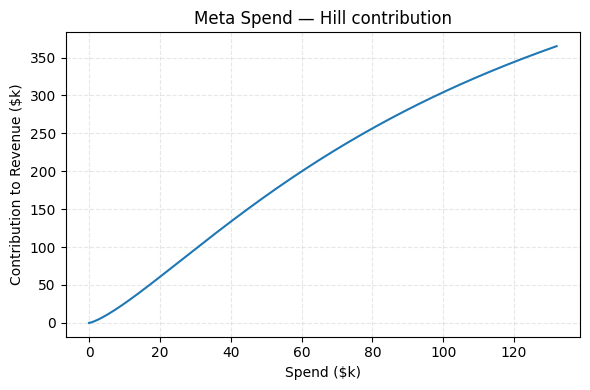

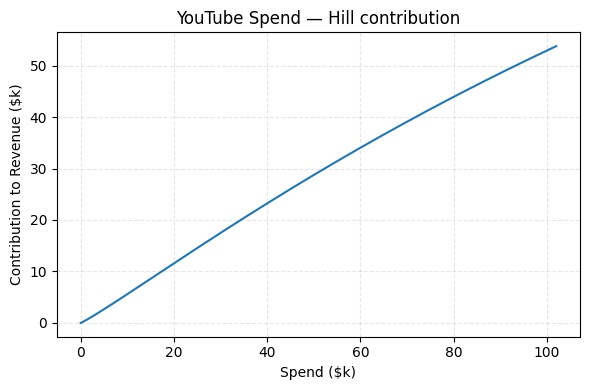

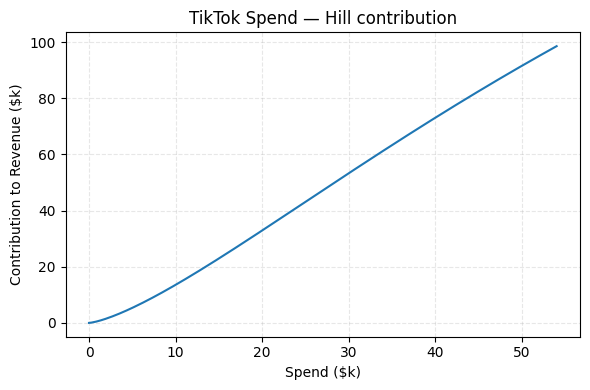

In [16]:
"""
H) Optional: visualize each channel's Hill term against a spend grid,
holding others at 0 (shows shape/plateau per channel).
"""
import matplotlib.pyplot as plt

for ch in channels:
    xs = np.linspace(0, df[ch].max()*1.2, 200)
    a, b, t = params[ch]["alpha"], params[ch]["beta"], params[ch]["theta"]
    ys = hill_term(xs, a, b, t)
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys)
    plt.title(f"{ch.replace('_',' ')} — Hill contribution")
    plt.xlabel("Spend ($k)"); plt.ylabel("Contribution to Revenue ($k)")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()


In [17]:
"""
Inspect model fit quality:
- Compare actual revenue (y) vs predicted revenue (yhat)
- Compute residuals (difference = actual - predicted)
"""

# --- Predicted scaled yhat (model outputs, scaled space)
yhat_scaled = multi_hill_scaled(Xs, res.x)

# --- Rescale back to original $k units
yhat = yhat_scaled * y_max
residuals = y - yhat

# --- Build comparison DataFrame
fit_check = pd.DataFrame({
    "Meta_Spend":    df["Meta_Spend"],
    "YouTube_Spend": df["YouTube_Spend"],
    "TikTok_Spend":  df["TikTok_Spend"],
    "Actual_y ($k)": np.round(y, 1),
    "Predicted_yhat ($k)": np.round(yhat, 1),
    "Residual (y - ŷ)": np.round(residuals, 1)
})

fit_check


,Meta_Spend,YouTube_Spend,TikTok_Spend,Actual_y ($k),Predicted_yhat ($k),Residual (y - ŷ)
0,40,30,15,350.0,350.0,0.0
1,50,40,20,400.0,400.0,0.0
2,60,45,25,445.0,445.0,0.0
3,70,55,25,480.0,480.0,0.0
4,80,60,30,520.0,520.0,0.0
5,90,70,35,560.0,560.0,0.0
6,100,75,40,595.0,595.0,0.0
7,110,85,45,630.0,630.0,0.0


### Accuracy Metrics

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2  = r2_score(y, yhat)
mae = mean_absolute_error(y, yhat)

# Backward-compatible RMSE:
mse  = mean_squared_error(y, yhat)   # always returns MSE
rmse = np.sqrt(mse)                  # take square root for RMSE

# rmse = mean_squared_error(y, yhat, squared=False) # newer sklearn versions

print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.2f}k")
print(f"RMSE = {rmse:.2f}k")

R² = 1.000
MAE = 0.00k
RMSE = 0.00k


### Actual vs. Predicted Fit Check Plot

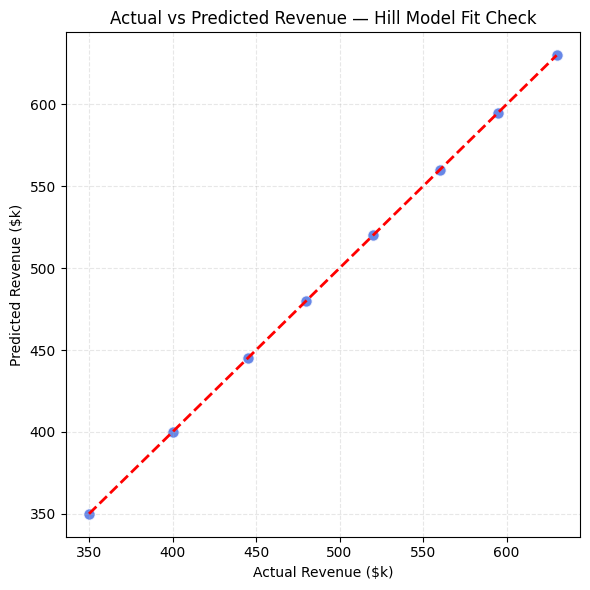

In [ ]:
"""
Fit check plot:
Shows how close the predicted values (yhat) are to actual revenues (y).

Interpretation:
- Points near the diagonal line → model predicts accurately.
- Points above → model under-predicts (actual > predicted).
- Points below → model over-predicts (predicted > actual).
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y, yhat, color="royalblue", alpha=0.8, edgecolor="white", s=70)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # diagonal reference
plt.xlabel("Actual Revenue ($k)")
plt.ylabel("Predicted Revenue ($k)")
plt.title("Actual vs Predicted Revenue — Hill Model Fit Check")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# The closer all your blue dots are to the red diagonal,
# the better your Hill model captures the real relationship between ad spend and revenue.


### StateGraph multi-channel agent (Meta + TikTok) that (1) extracts spends per channel from a free-text user query via a Supervisor, then (2) returns a structured output using your Hill-based multi-channel predictor.

In [ ]:
"""
Multi-channel LangGraph agent (StateGraph) for "what if" queries:
- Channels: Meta, TikTok
- Supervisor extracts spends (in $k) from natural language
- Predictor returns structured output with estimated revenue

Assumptions:
- You have `predict_revenue_multichannel({"Meta_Spend": x, "TikTok_Spend": y}) -> float`
- Units are $k (thousands of dollars)
"""
from typing import Annotated, Literal, Optional
from operator import add
import re

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.types import Command
from pydantic import BaseModel

# -----------------------------
# 0) LLM for routing (supervisor)
# -----------------------------
routing_llm = AzureChatOpenAI(
    model="gpt-4o",
    api_key=azure_openai_api_key,
    api_version="2024-12-01-preview",
    azure_endpoint=azure_openai_endpoint,
    temperature=0.2,
)

# -----------------------------
# 1) Agent state
# -----------------------------
class AgentState(MessagesState):
    next: Optional[str] = None
    routed_intent: Annotated[list[str], add]
    meta_k: Optional[float] = None
    tiktok_k: Optional[float] = None

# -----------------------------
# 2) Structured routing schema
# -----------------------------
class RouteDecision(BaseModel):
    target: Literal["Predictor", "FINISH"]
    reason: str
    # spends in thousands of dollars ($k)
    meta_k: Optional[float] = None
    tiktok_k: Optional[float] = None

# -----------------------------
# 3) Routing prompt (extract spends + intent)
# -----------------------------
routing_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "You are the supervisor for a marketing assistant.\n"
                "Extract *per-channel* spends (in thousands of dollars, $k) for Meta and TikTok from the user's query.\n"
                "Return a JSON object with fields: `target`, `reason`, `meta_k`, `tiktok_k`.\n\n"
                "Routing rule:\n"
                "- If the user is asking for estimated revenue given spends on Meta and/or TikTok, set `target` to `Predictor`.\n"
                "- Otherwise set `target` to `FINISH`.\n\n"
                "Unit parsing rules (examples → store in $k):\n"
                "- '10k', '10 k', '10,000', '10,000 dollars' → 10.0\n"
                "- '0.5 million', '500k' → 500.0\n"
                "- If plain dollars like '25000' appear, interpret as 25.0k.\n"
                "- If a channel isn't mentioned, set that channel's value to null.\n"
                "- Channel synonyms: Meta = ['meta','facebook','fb']; TikTok = ['tiktok','tt'].\n"
                "Do NOT make up spends; use null if not present."
            )
        ),
        ("user", "{query}"),
    ]
)

routing_chain = routing_prompt | routing_llm.with_structured_output(RouteDecision)

def _select_next(state: AgentState) -> str:
    return state.get("next", "FINISH")

# -----------------------------
# 4) Supervisor node
# -----------------------------
def supervisor_node(state: AgentState):
    last_human = next(msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage))
    try:
        decision = routing_chain.invoke({"query": last_human.content})
    except Exception as exc:
        error_msg = AIMessage(content=f"Routing failed to parse: {exc}")
        return Command(
            update={
                "next": "FINISH",
                "messages": [error_msg],
                "routed_intent": ["routing_error"],
                "meta_k": None,
                "tiktok_k": None,
            }
        )

    supervisor_note = AIMessage(content=f"Supervisor routing to {decision.target}: {decision.reason}")
    return Command(
        update={
            "next": decision.target,
            "meta_k": decision.meta_k,
            "tiktok_k": decision.tiktok_k,
            "routed_intent": [decision.reason],
            "messages": [supervisor_note],
        }
    )

# -----------------------------
# 5) Predictor node (uses your Hill-based multi-channel predictor)
# -----------------------------
def predictor_node(state: AgentState):
    meta_k = state.get("meta_k")
    tiktok_k = state.get("tiktok_k")

    if meta_k is None and tiktok_k is None:
        reply = (
            "I couldn’t detect a spend amount for Meta or TikTok. "
            "Please specify something like: 'Meta 60k and TikTok 25k'."
        )
        return Command(update={"messages": [AIMessage(content=reply)], "next": "FINISH"})

    # Default any missing channel to 0.0k
    spends = {
        "Meta_Spend": float(meta_k or 0.0),
        "TikTok_Spend": float(tiktok_k or 0.0),
    }

    try:
        est_rev_k = predict_revenue_multichannel(spends)  # <-- your previously defined function (returns $k)
    except Exception as exc:
        err = f"Prediction failed: {exc}"
        return Command(update={"messages": [AIMessage(content=err)], "next": "FINISH"})

    # Structured output payload
    payload = {
        "inputs": {
            "Meta_Spend_k": spends["Meta_Spend"],
            "TikTok_Spend_k": spends["TikTok_Spend"],
        },
        "estimate": {
            "Revenue_k": round(est_rev_k, 2),
            "Revenue_usd": round(est_rev_k * 1000.0, 2),
            "model": "Multi-channel Hill (plateau/steepness/half-sat per channel) + baseline",
        },
        "notes": [
            "Units are thousands of dollars ($k).",
            "If a channel spend is omitted, it is treated as 0.0k.",
            "Parameters were fitted offline and cached; no refit during this call.",
        ],
    }

    # reply = (
    #     "Here is the structured estimate:\n"
    #     f"```json\n{payload}\n```"
    # )
    reply = (
    "Here’s what the model projects:\n"
    f"- Meta spend: ${spends['Meta_Spend']:.1f}k\n"
    f"- TikTok spend: ${spends['TikTok_Spend']:.1f}k\n"
    f"- Expected revenue: ${est_rev_k:.1f}k (≈ ${est_rev_k * 1_000:,.0f})\n"
    "\nAssumptions: units are thousands of dollars, omitted channels default to 0k, "
    "and parameters come from the cached Hill fit."
)

    return Command(update={"messages": [AIMessage(content=reply)], "next": "FINISH"})

# -----------------------------
# 6) Assemble the StateGraph
# -----------------------------
graph = StateGraph(AgentState)
graph.add_node("supervisor", supervisor_node)
graph.add_node("Predictor", predictor_node)
graph.add_edge(START, "supervisor")
graph.add_conditional_edges("supervisor", _select_next, {"Predictor": "Predictor", "FINISH": END})
graph.add_edge("Predictor", END)

multi_channel_agent = graph.compile()


# Example query
q1 = "What if I spend 60k on Meta and 25k on TikTok?"
q2 = "Estimate revenue if Meta is 80,000 dollars and TikTok is 15k."

result = multi_channel_agent.invoke({"messages": [HumanMessage(content="What if I spend 60k on Meta and 25k on TikTok?")]})
print(result["messages"][-1].content)

Here’s what the model projects:
- Meta spend: $60.0k
- TikTok spend: $25.0k
- Expected revenue: $419.0k (≈ $418,981)

Assumptions: units are thousands of dollars, omitted channels default to 0k, and parameters come from the cached Hill fit.
